<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week12-SVM/SVM-Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
#Credit: https://github.com/python-engineer/MLfromscratch
import numpy as np 
import matplotlib.pyplot as plt
import random

class SVM:

    def __init__(self, learning_rate=0.01, penalty_rate=0.1, niter =1000):
        self.lr = learning_rate
        self.n_iters = niter
        self.w = None
        self.b = None
        self.penalty_rate = penalty_rate

    def fit(self, X, y):
        n_samples, n_features = X.shape  
        self.w = np.array([0,0])
        self.b = 0
        X_ = X
        y_ = y
        self.d = 1
        C = 1

        for i in range(self.n_iters):
          
          #idx is index, x_i is a vector
          for idx, x_i in enumerate(X_):
            eq = y_[idx] * (np.dot(x_i, self.w) + self.b)
            #print(eq)
            
            condition = (eq >= self.d) # True or False
            
            if condition:
              self.w = self.w - self.lr * (self.penalty_rate * self.w)
            
            else: #misclassified
              self.w = self.w - self.lr * ( self.penalty_rate * self.w - (C * np.multiply(x_i, y_[idx])))
              self.b = self.b - self.lr * C * (-1 * y_[idx]) 
          
            
          if i% (self.n_iters/10) == 0:
            print("i= ",i," W = ",self.w," b = ",self.b)

          if i == self.n_iters-1:
            self.visualize_svm(self.w, self.b, X, y)
                   
    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)
    
    def visualize_svm(self, w, b, X, y):

        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        plt.scatter(X[:,0], X[:,1], marker='o',c=y)
        #plt.ylim(-20, 20)
        #plt.xlim(-20,20)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x0_1 = np.amin(X[:,0])
        x0_2 = np.amax(X[:,0])

        x1_1 = get_hyperplane_value(x0_1, w, b, 0)
        x1_2 = get_hyperplane_value(x0_2, w, b, 0)

        x1_1_m = get_hyperplane_value(x0_1, w, b, -self.d)
        x1_2_m = get_hyperplane_value(x0_2, w, b, -self.d)

        x1_1_p = get_hyperplane_value(x0_1, w, b, self.d)
        x1_2_p = get_hyperplane_value(x0_2, w, b, self.d)

        ax.plot([x0_1, x0_2],[x1_1, x1_2], 'b--')
        ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'g')
        ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'r')

        x1_min = np.amin(X[:,1])
        x1_max = np.amax(X[:,1])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        plt.show()

    

i=  0  W =  [0.01798401 0.00999   ]  b =  0.01
i=  100  W =  [1.1436081  0.72041281]  b =  0.2700000000000001
i=  200  W =  [1.19091868 0.81269402]  b =  0.19
i=  300  W =  [1.16774606 0.85258649]  b =  0.14999999999999997
i=  400  W =  [1.13379606 0.88308378]  b =  0.12999999999999995
i=  500  W =  [1.12258593 0.89631947]  b =  0.11999999999999995
i=  600  W =  [1.1106594  0.88845041]  b =  0.10999999999999996
i=  700  W =  [1.11639566 0.89063781]  b =  0.10999999999999996
i=  800  W =  [1.12231484 0.89280872]  b =  0.10999999999999996
i=  900  W =  [1.12822132 0.89498339]  b =  0.10999999999999996


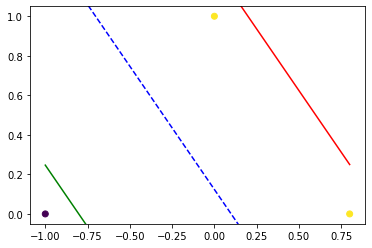

Our w= [1.10954698 0.88976445]  b= 0.10999999999999996
SVC  [[1.09756097 0.87804879]]   [0.12195121]


In [75]:
import numpy as np
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#X, y =  datasets.make_blobs(n_samples=20, n_features=2, centers=2, cluster_std=1, random_state=123)

X = np.array([[0.8,0.0],[0.0,1.0],[-1.0,0.0]])
y = np.array([1,1,0])

y = np.where(y == 0, -1, 1)
#print(X, " ", y)

clf = SVM(niter=1000)
clf.fit(X, y)
print("Our w=", clf.w, " b=", clf.b)

#Recommend
clf2 = SVC(kernel='linear')
#SVC(kernel="linear")
clf2.fit(X,y)
print("SVC ",clf2.coef_," ",clf2.intercept_)


In [76]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

array([[-1. ,  0. ],
       [ 0.8,  0. ],
       [ 0. ,  1. ]])

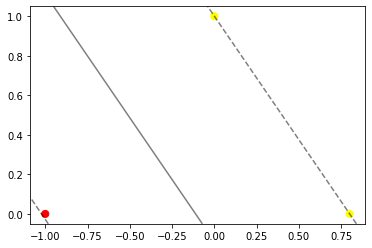

In [77]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf2);
clf2.support_vectors_

# Exercise
1. Create a hinge loss function and use it to check when to stop training.
2. Implement Stochastic GD version.